# Jie Shen Testing 2.0

Here we will try YOLO/YOLO-obb to draw some bounding boxes (Predicted vs Ground Truth)

Dependencies
```
%pip install torch torchvision torchaudio
%pip install opencv-python ultralytics
```

In [1]:
from datetime import datetime
from IPython.display import display, Markdown

display(Markdown(f'**Last Updated**: {datetime.now().isoformat()}'))

**Last Updated**: 2025-03-18T11:55:06.355151

In [7]:
%pip install -U pip wheel
%pip install dotenv

%pip install torch torchvision torchaudio
%pip install opencv-python ultralytics


  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Using cached dotenv-0.9.9-py2.py3-none-any.whl.metadata (279 bytes)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached dotenv-0.9.9-py2.py3-none-any.whl (1.9 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached torchaudio-2.6.0-cp311-cp311-win_amd64.whl.metadata (6.7 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached numpy-2.2

In [1]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()

sys.path.append(os.getenv('SRC_DIR'))

data_dir = os.getenv('DATA_DIR')
model_dir = os.getenv('MODEL_DIR')

## 1.0 Basic Data Understanding

### 1.1 Class Label Distribution

Here we check first the number of instances in each label class

In [3]:
def read_ground_truth(path: str):
    with open(path, 'r') as f:
        cls_xywhn = []

        for line in f:
            values = line.strip().split(' ')

            cls = int(values[0])

            x_n, y_n, w_n, h_n = map(float, values[1:])

            cls_xywhn.append((cls, x_n, y_n, w_n, h_n))

        return cls_xywhn
    
def xywhn_to_xyxy(image, x_n, y_n, w_n, h_n):
    # cv2 images in HWC
    height, width, _ = image.shape

    x1 = int((x_n - w_n / 2) * width)
    y1 = int((y_n - h_n / 2) * height)
    x2 = int((x_n + w_n / 2) * width)
    y2 = int((y_n + h_n / 2) * height)

    return x1, y1, x2, y2

In [9]:
import pandas as pd

train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

classes = []

for filename in os.listdir(train_labels_dir):
    cls_xywhn = read_ground_truth(os.path.join(train_labels_dir, filename))

    cls = [cls for cls, *_ in cls_xywhn]

    classes += cls

df_classes = pd.DataFrame(classes, columns=['Class'])

df_classes

Class
0          1
1          0
2          0
3          0
4          0
...      ...
10229      0
10230      0
10231      2
10232      1
10233      0

[10234 rows x 1 columns]

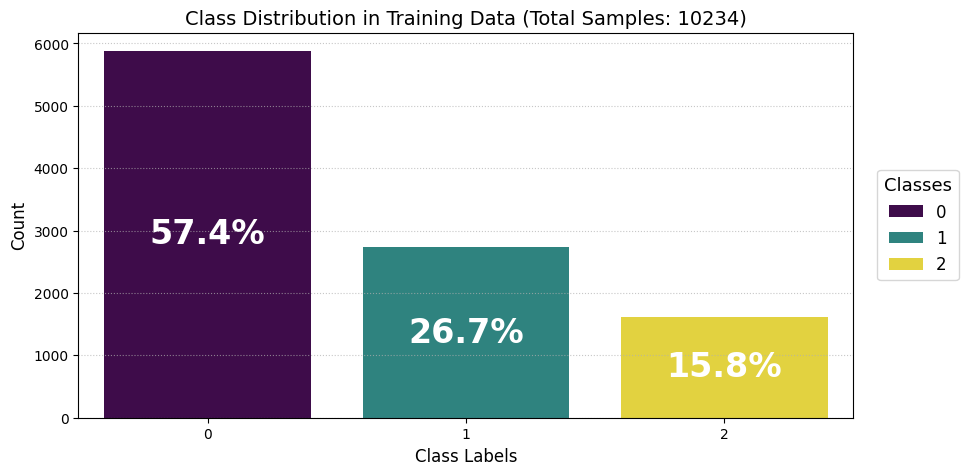

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

total_counts = len(df_classes['Class'])

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Class', data=df_classes, palette='viridis', hue='Class')

for p in ax.patches:
    # Get the height of the bar
    count = p.get_height()
    # Skip for zero counts
    if count > 0:
        # Calculate percentage
        percentage = f'{count / total_counts * 100:.1f}%' 
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() / 2, percentage, 
                ha='center', va='center', fontsize=24, color='white', fontweight='bold')
    
ax.grid(axis='y', linestyle=':', alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Classes', fontsize=12, title_fontsize=13, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Class Distribution in Training Data (Total Samples: {total_counts})', fontsize=14)

plt.show()

### 1.2 Sample Image Visualisation

Here we try to visualise a sample image, in order to figure out what the class label means

In [11]:
def get_filename_containing_classes(classes: set, labels_dir: str) -> str:
    for filename in os.listdir(labels_dir):
        cls_xywhn = read_ground_truth(os.path.join(labels_dir, filename))

        cls = [cls for cls, *_ in cls_xywhn]

        if set(cls) == classes:
            return filename.split('.')[0]

    return None

In [12]:
import cv2
from itertools import combinations

classes = df_classes['Class'].unique().tolist()

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

comb_imgs = []

for comb in [set(comb) for r in range(len([0, 1, 2]) + 1) for comb in combinations([0, 1, 2], r)]:
    sample_filename = get_filename_containing_classes(comb, train_labels_dir)

    if sample_filename is None:
        print(f'No sample found for classes: {comb}')
        continue

    sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
    cls_xywhns = read_ground_truth(os.path.join(train_labels_dir, f'{sample_filename}.txt'))

    for cls, *xywhn in cls_xywhns:
        xyxy = xywhn_to_xyxy(sample_img, *xywhn)
        cv2.rectangle(sample_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 5)
        cv2.putText(sample_img, f'Class: {str(cls)}', (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)

    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    comb_imgs.append((comb, sample_img))

No sample found for classes: set()


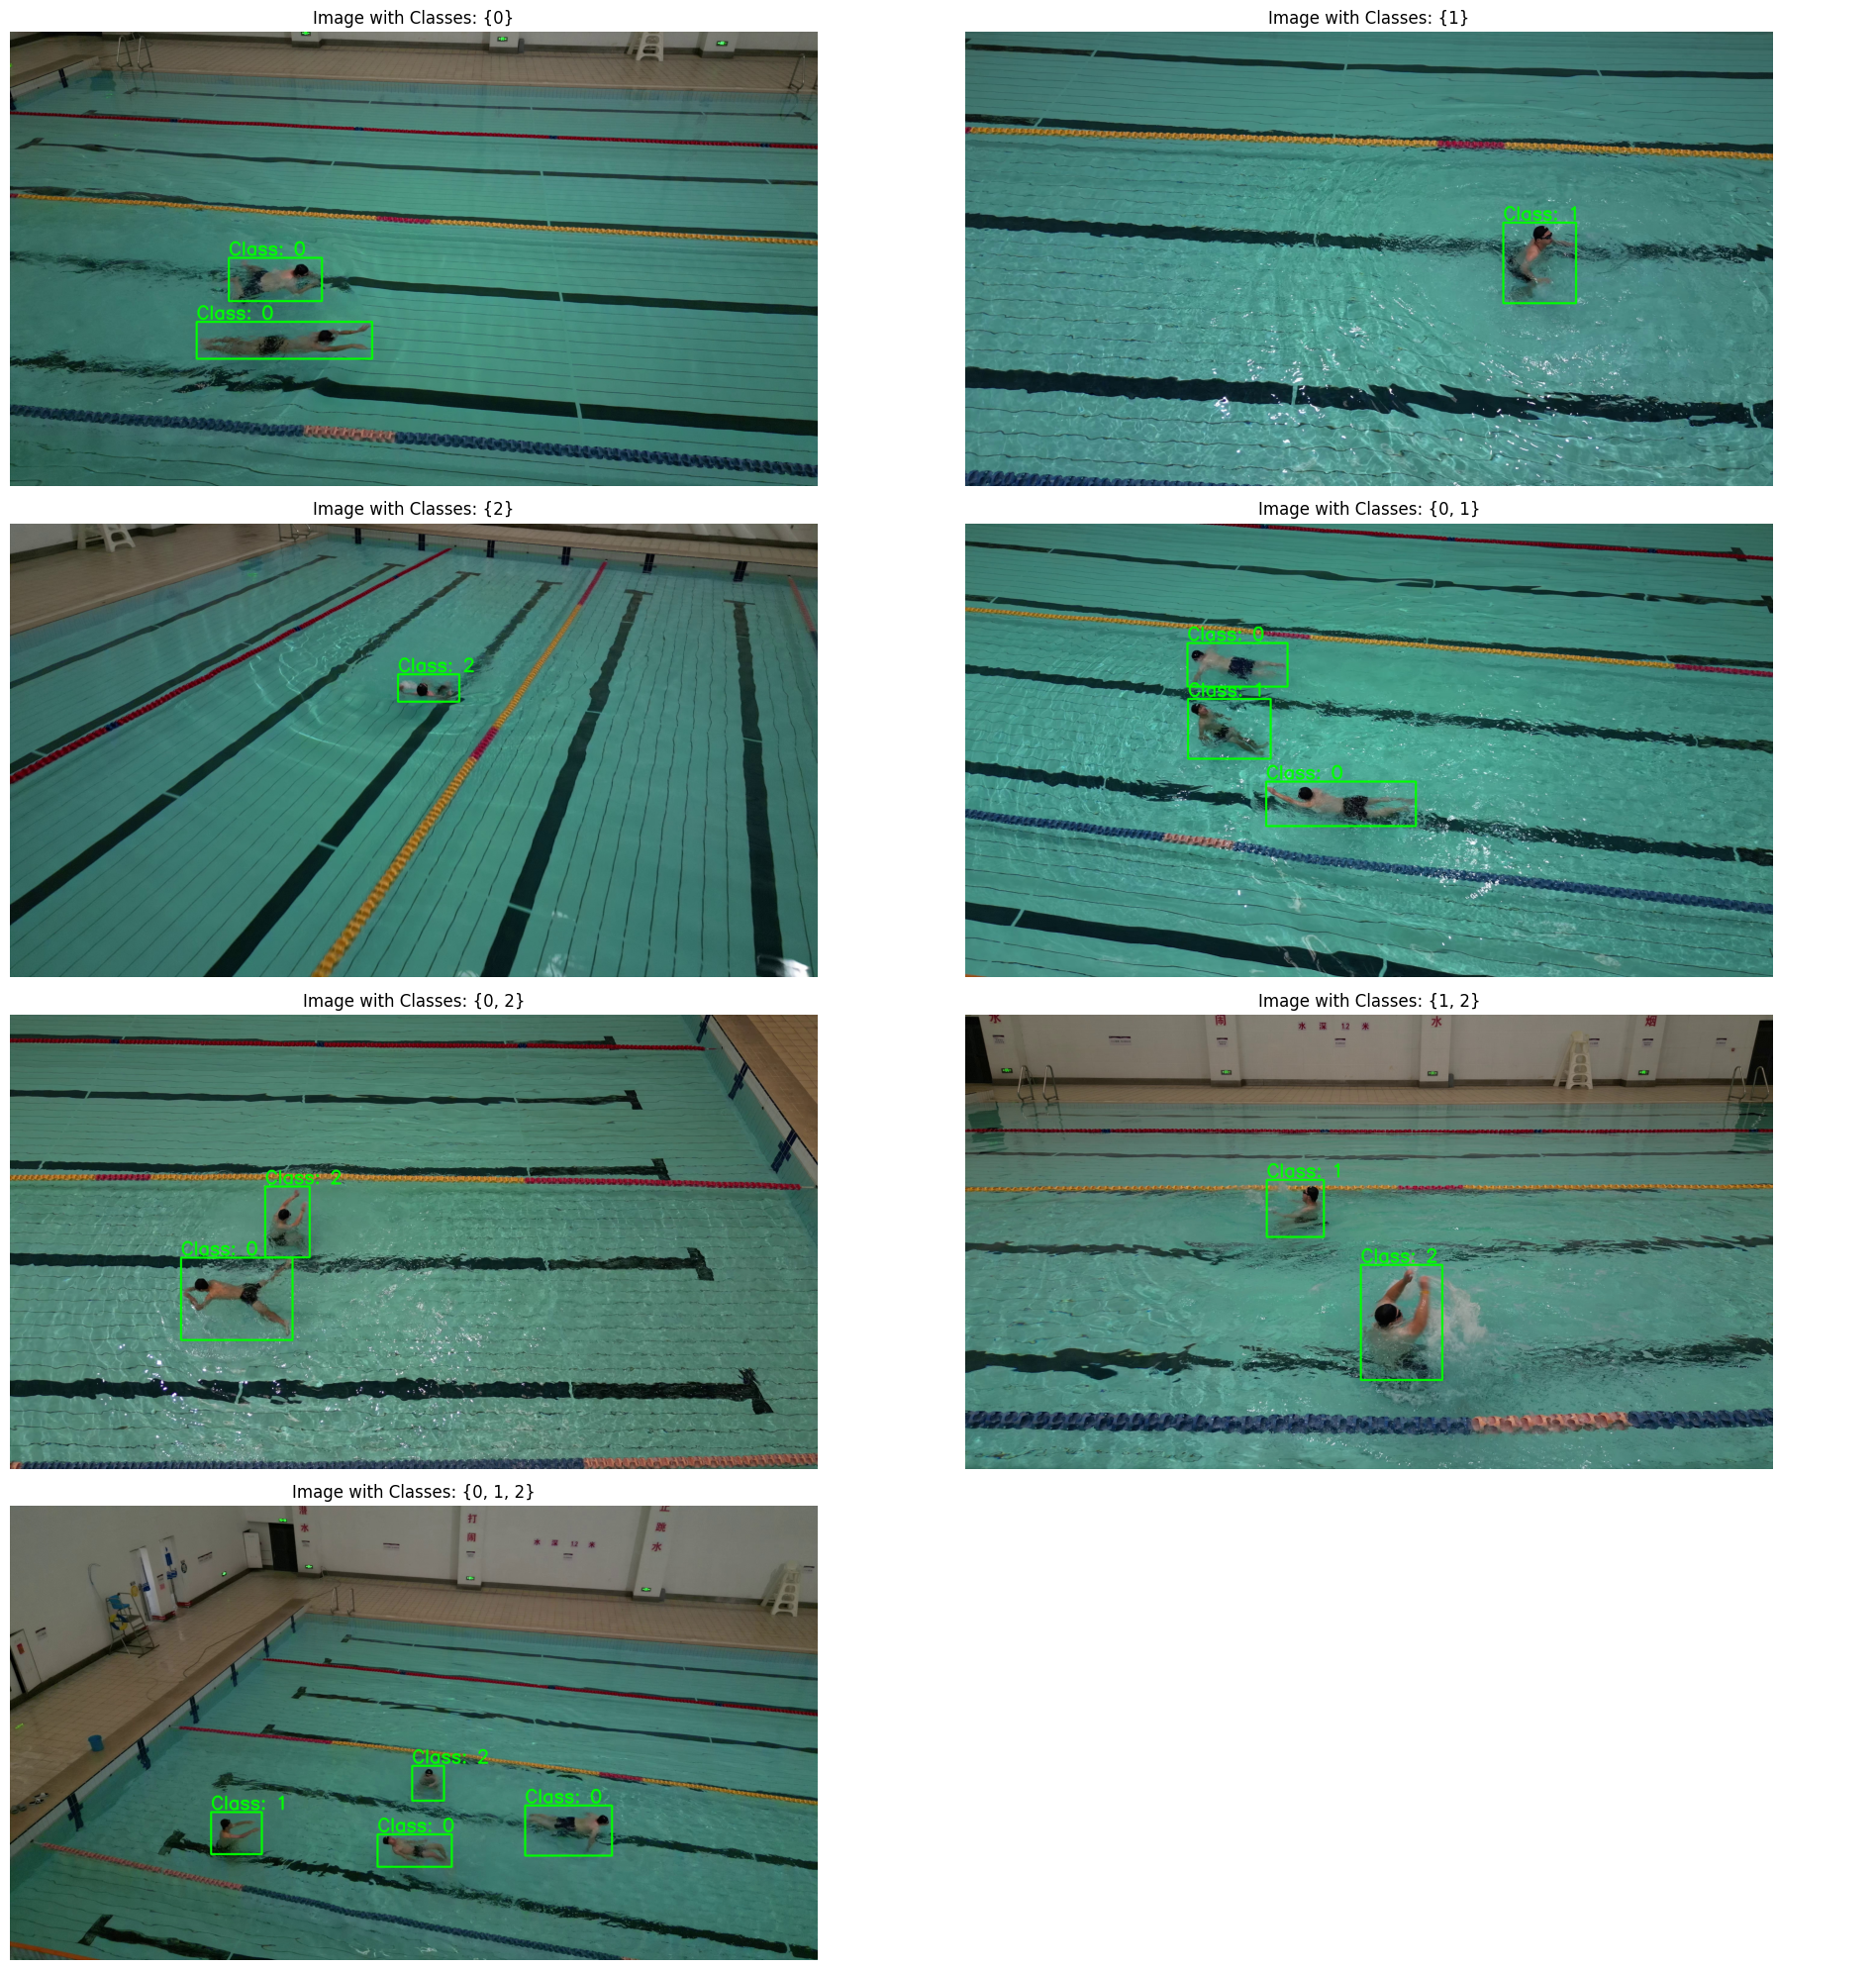

In [13]:
import matplotlib.pyplot as plt

num_imgs = len(comb_imgs)
num_cols = 2
num_rows = (num_imgs // num_cols) + (num_imgs % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

axes = axes.flatten()

for i, (comb, img) in enumerate(comb_imgs):
    axes[i].imshow(img)
    axes[i].set_title(f'Image with Classes: {comb}', fontsize=12)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 1.2 Sample Images for Classes

Here we display some sample cropped images for each class

Therefore, we can conclude that:
- 0 corresponds to **swimming**
- 1 corresponds to **tread water**
- 2 corresponds to **drowning**

In [14]:
import cv2

classes = df_classes['Class'].unique().tolist()

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

cls_imgs = []

for cls in [set([cls]) for cls in classes]:
    sample_filename = get_filename_containing_classes(cls, train_labels_dir)

    if sample_filename is None:
        print(f'No sample found for classes: {cls}')
        continue

    sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
    cls_xywhn = read_ground_truth(os.path.join(train_labels_dir, f'{sample_filename}.txt'))[0]

    cls, *xywhn = cls_xywhn
    xyxy = xywhn_to_xyxy(sample_img, *xywhn)

    sample_img = sample_img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]

    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    cls_imgs.append((cls, sample_img))

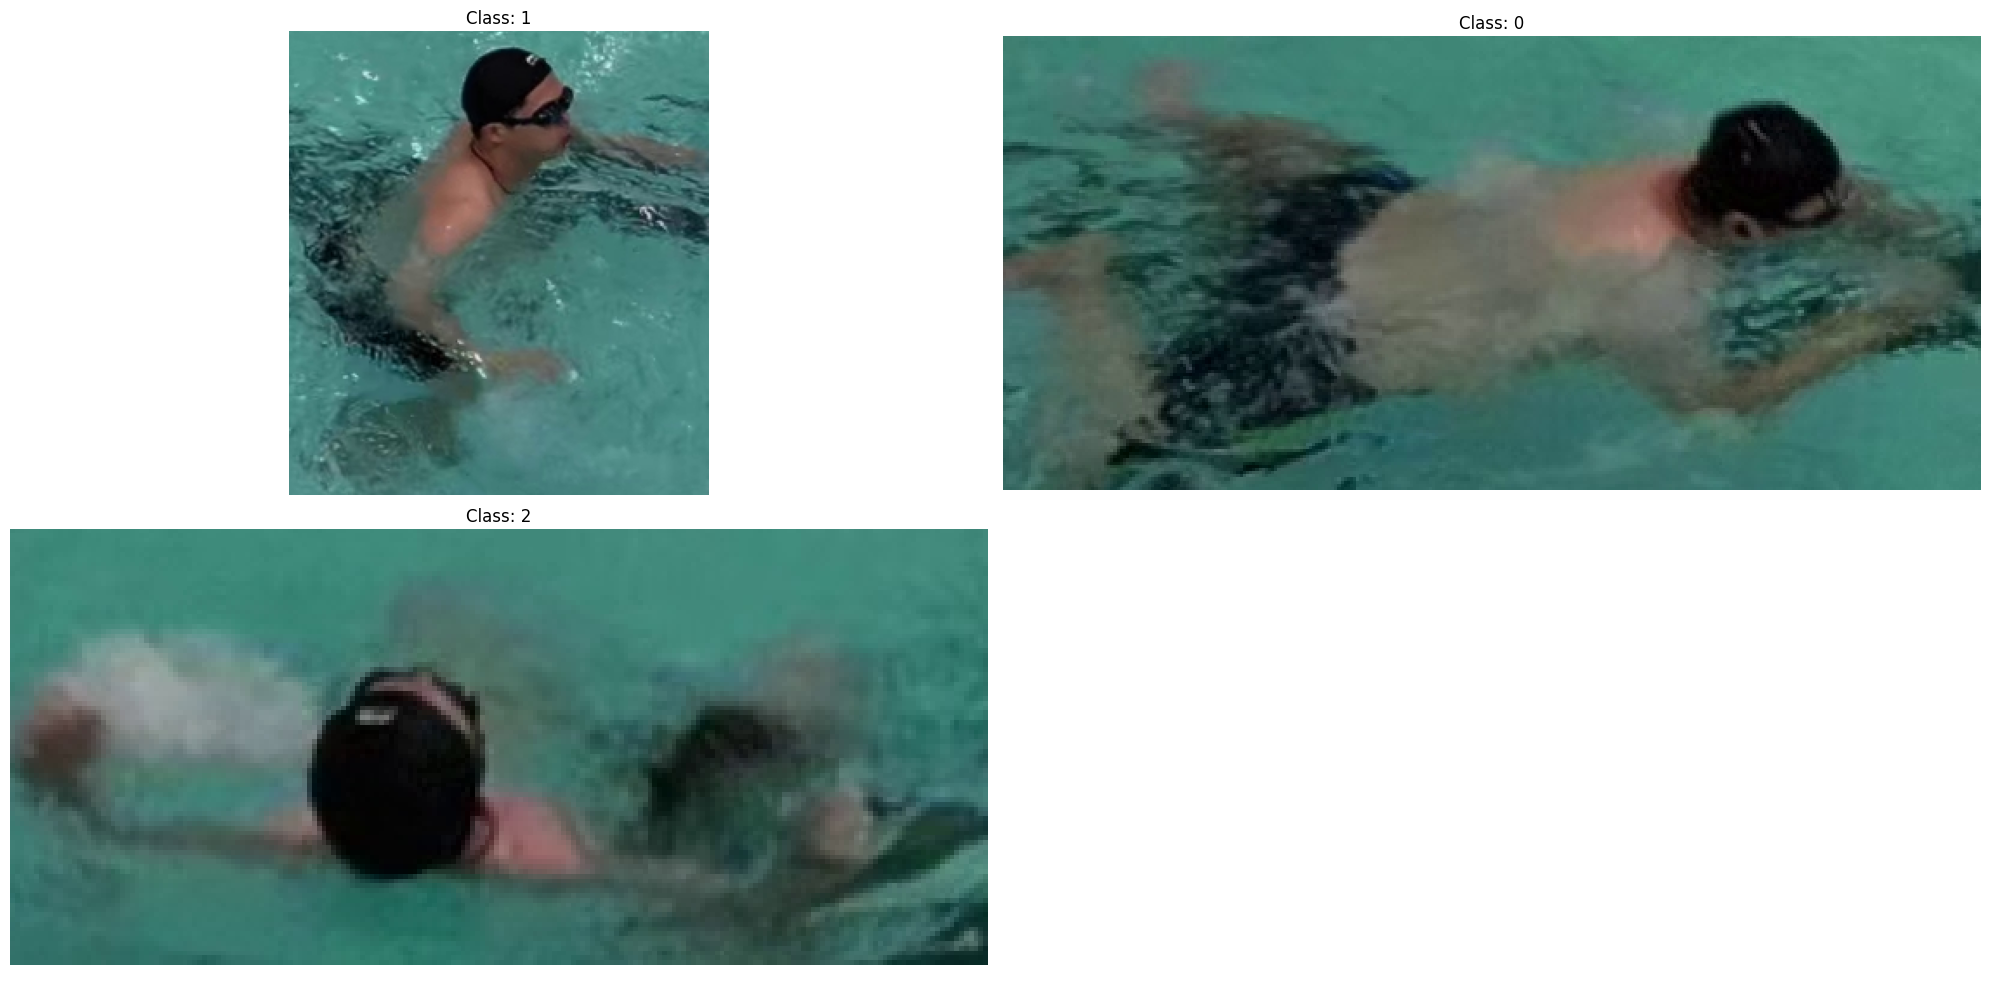

In [15]:
import matplotlib.pyplot as plt

num_imgs = len(cls_imgs)
num_cols = 2
num_rows = (num_imgs // num_cols) + (num_imgs % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

axes = axes.flatten()

for i, (cls, img) in enumerate(cls_imgs):
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {cls}', fontsize=12)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 1.3 Visualising Different Channels of Images

Here we visualise different channels of an image seperately, to understand the contribution of each channel to the orignal image

In [16]:
import cv2
import re

train_img_dir = os.path.join(data_dir, os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_labels_dir = os.path.join(data_dir, os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))

sample_filename = '000434'

sample_img = cv2.imread(os.path.join(train_img_dir, f'{sample_filename}.jpg'))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

format_imgs = []

for color_space in ['RGB', 'HSV', 'LAB', 'YCbCr']:
    cv_convert = cv2.COLOR_BGR2HSV if color_space == 'HSV' else cv2.COLOR_BGR2LAB if color_space == 'LAB' else cv2.COLOR_BGR2YCrCb if color_space == 'YCbCr' else None
    
    if color_space == 'RGB':
        transformed_img = sample_img
    else:
        transformed_img = cv2.cvtColor(sample_img, cv_convert)

    channels = re.findall(r'[A-Z][a-z]*', color_space)

    format_imgs.append((color_space, channels, sample_img, transformed_img))

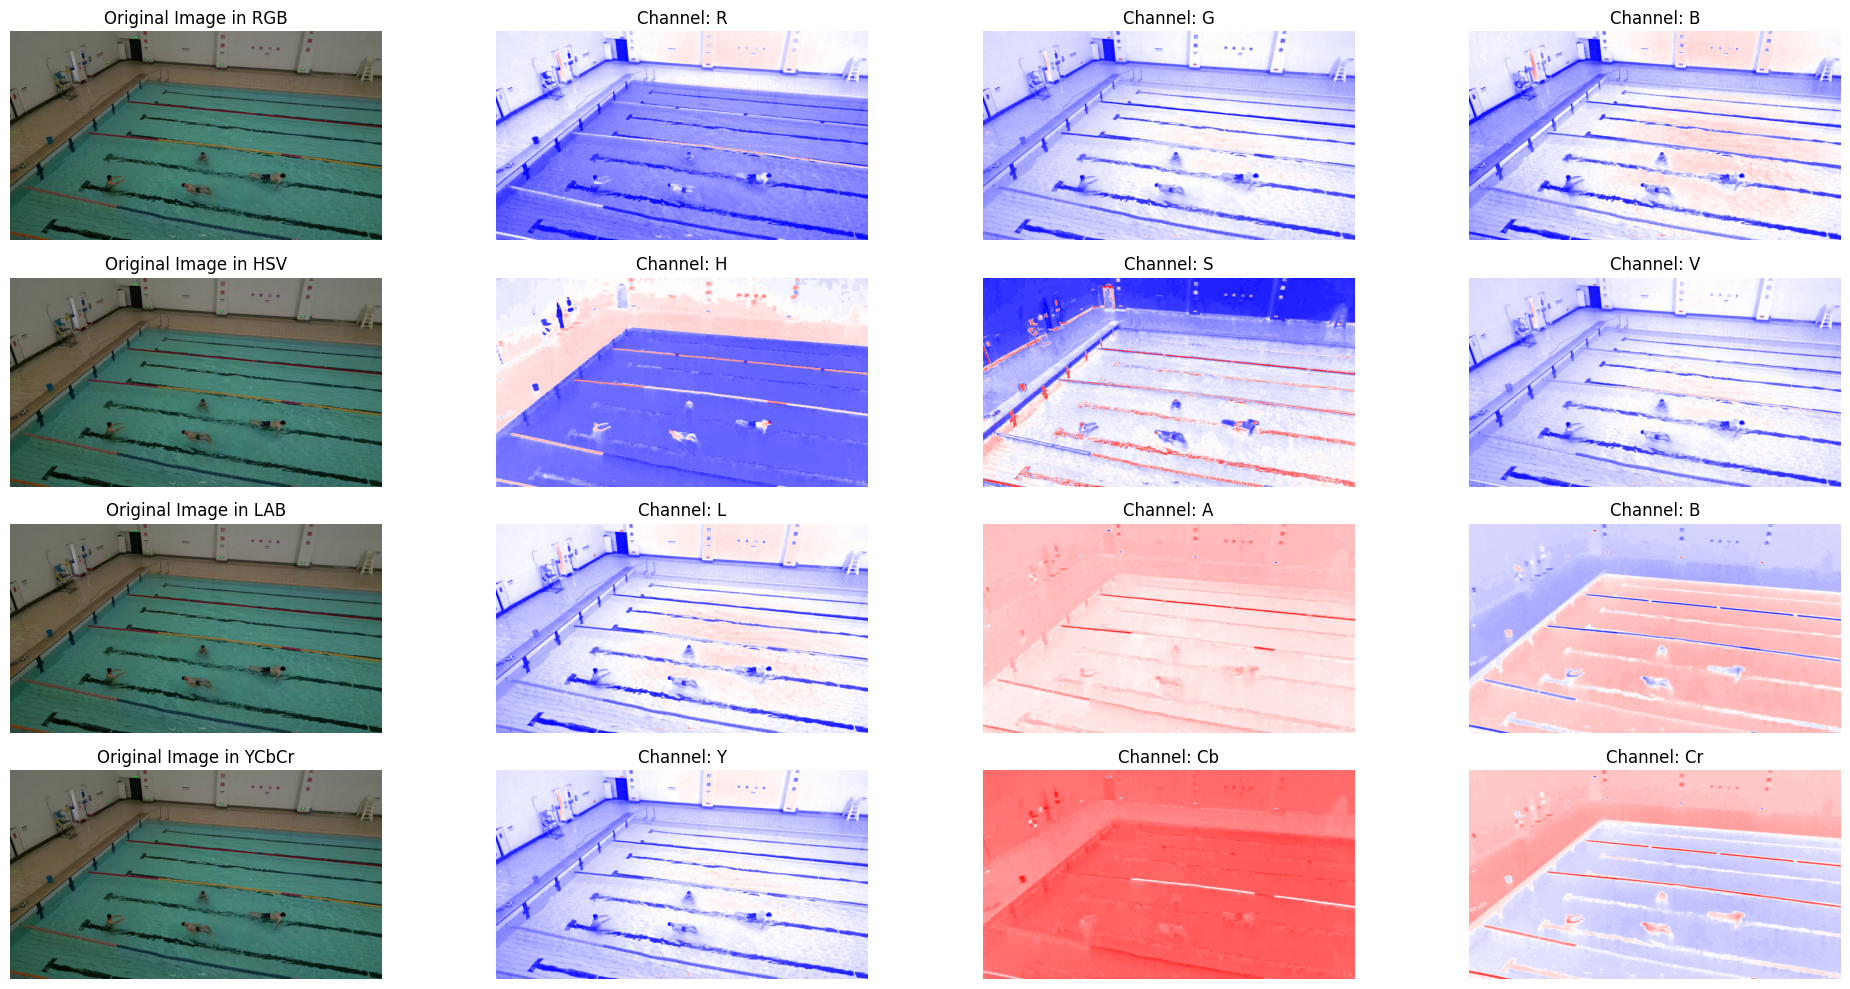

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(format_imgs), 4, figsize=(20, 10))

axes = axes.flatten()

for i, (color_space, channels, orignal_img, transformed_img) in enumerate(format_imgs):
    ax_num = i * 4
    axes[ax_num].imshow(orignal_img)
    axes[ax_num].set_title(f'Original Image in {color_space}', fontsize=12)
    axes[ax_num].axis('off')

    for j, channel in enumerate(channels):
        ax_num = i * 4 + j + 1
        axes[ax_num].imshow(transformed_img[:, :, j], cmap='bwr')
        axes[ax_num].set_title(f'Channel: {channel}', fontsize=12)
        axes[ax_num].axis('off')

plt.tight_layout()
plt.show()

## 2.0 Human Detection

Now here we use different variants of YOLO for human detection

In [15]:
import numpy as np

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    denominator = float(boxAArea + boxBArea - interArea)
    
    return interArea / denominator if denominator > 0 else 0 

def calculate_precision_recall(predictions, ground_truths, iou_threshold=0.5):
    TP, FP, FN = 0, 0, 0
    image_list = set([gt[0] for gt in ground_truths])  # Unique images

    for image_name in image_list:
        img_preds = [p for p in predictions if p[0] == image_name]
        img_gts = [g for g in ground_truths if g[0] == image_name]

        matched_gts = set()
        
        for pred_box in img_preds:
            best_iou = 0
            best_gt_idx = None

            for i, gt_box in enumerate(img_gts):
                iou = compute_iou(gt_box[1:5], pred_box[1:5])

                if iou > best_iou and iou > iou_threshold and i not in matched_gts:
                    best_iou = iou
                    best_gt_idx = i

            if best_gt_idx is not None:
                TP += 1
                matched_gts.add(best_gt_idx)
            else:
                FP += 1

        FN += len(img_gts) - len(matched_gts)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

def calculate_ap(precision, recall):
    precision = np.array(precision)
    recall = np.array(recall)
    precision = np.maximum.accumulate(precision[::-1])[::-1]  # Ensure non-decreasing precision
    return np.trapz(precision, recall)  # Area under curve

def calculate_map(predictions, ground_truths, iou_thresholds=None):
    iou_thresholds = iou_thresholds or np.arange(0.5, 1.0, 0.05)  # IoU thresholds: 0.50 to 0.95
    ap_values = []

    confidence_thresholds = np.linspace(0, 1, 101)  # 101 confidence thresholds

    for iou_thresh in iou_thresholds:
        precision_recall_pairs = []

        for conf_thresh in confidence_thresholds:
            conf_filtered_preds = [p for p in predictions if p[5] >= conf_thresh]
            precision, recall = calculate_precision_recall(conf_filtered_preds, ground_truths, iou_thresh)
            precision_recall_pairs.append((precision, recall))

        # Sort by recall values
        precision_recall_pairs.sort(key=lambda x: x[1])
        recall_values = [pair[1] for pair in precision_recall_pairs]
        precision_values = [pair[0] for pair in precision_recall_pairs]

        # Compute AP at this IoU threshold
        ap = calculate_ap(precision_values, recall_values)
        ap_values.append(ap)

    return np.mean(ap_values)

In [16]:
val_labels_dir = os.path.join(os.getenv('LABEL_DIR'), os.getenv('VAL_DIR'))
val_img_dir = os.path.join(os.getenv('IMG_DIR'), os.getenv('VAL_DIR'))

ground_truths = []

for path in os.listdir(val_labels_dir):
    name, ext = os.path.splitext(path)

    cls_xywhn = read_ground_truth(os.path.join(val_labels_dir, path))
    img = cv2.imread(os.path.join(val_img_dir, f'{name}.jpg'))

    for _, *xywhn in cls_xywhn:
        xyxy = [name, *xywhn_to_xyxy(img, *xywhn)]
        ground_truths.append(xyxy)

In [17]:
from ultralytics import YOLO
import torch
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

yolo_dir = os.getenv('YOLO_DIR')
model_lists = os.listdir(yolo_dir)

yolov11n = YOLO(os.path.join(yolo_dir, model_lists[2])).to(device)

predictions_yolov11n = []
CLASS_HUMAN = 0

results = yolov11n(val_img_dir, stream=True)  # Process images in a streaming mode

for result in results:
    filename = os.path.basename(result.path)  # Get the filename
    name, ext = os.path.splitext(filename)

    for box in result.boxes.data:
        x1, y1, x2, y2, conf, cls = box.tolist()

        if int(cls) == CLASS_HUMAN:
            predictions_yolov11n.append([name, x1, y1, x2, y2, conf])


image 1/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000038.jpg: 384x640 1 person, 1 surfboard, 664.5ms
image 2/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000073.jpg: 384x640 (no detections), 391.6ms
image 3/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000076.jpg: 384x640 5 persons, 389.9ms
image 4/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000079.jpg: 384x640 1 dog, 326.9ms
image 5/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000083.jpg: 384x640 2 persons, 1 chair, 1 refrigerator, 347.3ms
image 6/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000088.jpg: 384x640 1 bird, 332.6ms
image 7/1572 C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\val\000097.jpg: 384x640 2 persons, 1 bird, 362.8ms
image 8/1572 C:\Users\hp\Downloads\BMCS 2133 

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
import torch
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

yolo_dir = os.getenv('YOLO_DIR')
model_lists = os.listdir(yolo_dir)

yolov11s = YOLO(os.path.join(yolo_dir, model_lists[3])).to(device)

predictions_yolov11s = []
CLASS_HUMAN = 0

results = yolov11n(val_img_dir, stream=True)  # Process images in a streaming mode

for result in results:
    filename = os.path.basename(result.path)  # Get the filename
    name, ext = os.path.splitext(filename)

    for box in result.boxes.data:
        x1, y1, x2, y2, conf, cls = box.tolist()

        if int(cls) == CLASS_HUMAN:
            predictions_yolov11s.append([name, x1, y1, x2, y2, conf])

In [ ]:
evaluation_summary = {
    'YOLOv11n': {
        'Precision': 0,
        'Recall': 0,
        'mAP@0.5': 0,
        'mAP@0.5:0.95': 0
    },
    'YOLOv11s': {
        'Precision': 0,
        'Recall': 0,
        'mAP@0.5': 0,
        'mAP@0.5:0.95': 0
    }
}

for model, predictions in zip(['YOLOv11n', 'YOLOv11s'], [predictions_yolov11n, predictions_yolov11s]):
    precision, recall = calculate_precision_recall(predictions, ground_truths)
    mAP = calculate_map(predictions, ground_truths)

    evaluation_summary[model]['Precision'] = precision
    evaluation_summary[model]['Recall'] = recall
    evaluation_summary[model]['mAP@0.5'] = mAP

Calculating AP@0.50
Confidence Threshold: 0.00, Predictions: 1777
Confidence Threshold: 0.01, Predictions: 1777
Confidence Threshold: 0.02, Predictions: 1777
Confidence Threshold: 0.03, Predictions: 1777
Confidence Threshold: 0.04, Predictions: 1777
Confidence Threshold: 0.05, Predictions: 1777
Confidence Threshold: 0.06, Predictions: 1777
Confidence Threshold: 0.07, Predictions: 1777
Confidence Threshold: 0.08, Predictions: 1777
Confidence Threshold: 0.09, Predictions: 1777
Confidence Threshold: 0.10, Predictions: 1777
Confidence Threshold: 0.11, Predictions: 1777
Confidence Threshold: 0.12, Predictions: 1777
Confidence Threshold: 0.13, Predictions: 1777
Confidence Threshold: 0.14, Predictions: 1777
Confidence Threshold: 0.15, Predictions: 1777
Confidence Threshold: 0.16, Predictions: 1777
Confidence Threshold: 0.17, Predictions: 1777
Confidence Threshold: 0.18, Predictions: 1777
Confidence Threshold: 0.19, Predictions: 1777
Confidence Threshold: 0.20, Predictions: 1777
Confidence Thr

C:\Users\hp\AppData\Local\Temp\ipykernel_4532\1173791886.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(precision, recall)  # Area under curve


AP@0.50: 0.2585
Calculating AP@0.55
Confidence Threshold: 0.00, Predictions: 1777
Confidence Threshold: 0.01, Predictions: 1777
Confidence Threshold: 0.02, Predictions: 1777
Confidence Threshold: 0.03, Predictions: 1777
Confidence Threshold: 0.04, Predictions: 1777
Confidence Threshold: 0.05, Predictions: 1777
Confidence Threshold: 0.06, Predictions: 1777
Confidence Threshold: 0.07, Predictions: 1777
Confidence Threshold: 0.08, Predictions: 1777
Confidence Threshold: 0.09, Predictions: 1777
Confidence Threshold: 0.10, Predictions: 1777
Confidence Threshold: 0.11, Predictions: 1777
Confidence Threshold: 0.12, Predictions: 1777
Confidence Threshold: 0.13, Predictions: 1777
Confidence Threshold: 0.14, Predictions: 1777
Confidence Threshold: 0.15, Predictions: 1777
Confidence Threshold: 0.16, Predictions: 1777
Confidence Threshold: 0.17, Predictions: 1777
Confidence Threshold: 0.18, Predictions: 1777
Confidence Threshold: 0.19, Predictions: 1777
Confidence Threshold: 0.20, Predictions: 177

# HSV Conversion for Human Contour Detection

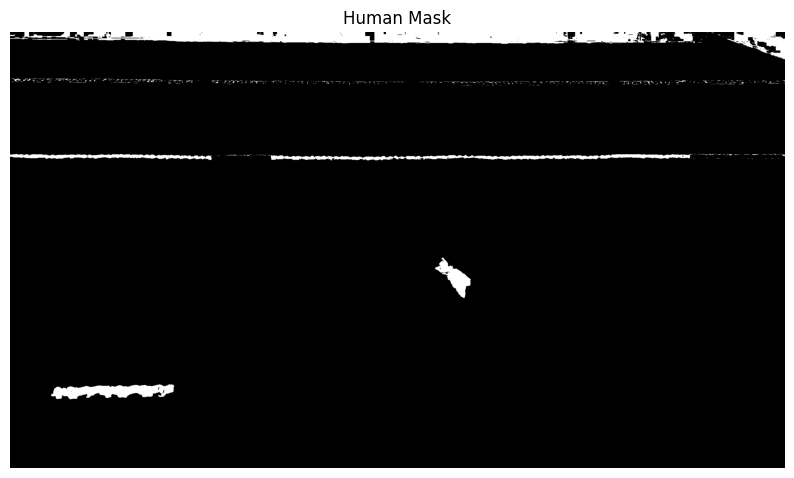

(np.float64(-0.5), np.float64(2687.5), np.float64(1511.5), np.float64(-0.5))

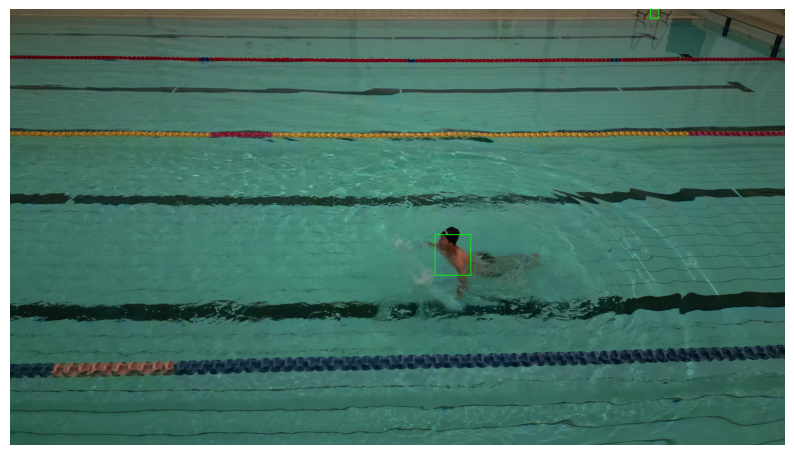

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread(r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000111.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define masks for different skin tones and clothing (black shorts)
lower_skin = np.array([0, 30, 60])  # Lower HSV range for skin
upper_skin = np.array([20, 255, 255])  # Upper HSV range for skin

# lower_cloth = np.array([0, 0, 0])  # Lower HSV range for black shorts
# upper_cloth = np.array([180, 255, 60])  # Upper HSV range for black shorts

# Create masks
skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)
# cloth_mask = cv2.inRange(hsv, lower_cloth, upper_cloth)

# Combine masks to get full body
mask = skin_mask
# mask = cv2.bitwise_or(skin_mask, cloth_mask)

# Morphological operations to remove noise
# kernel = np.ones((5,5), np.uint8)
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    if cv2.contourArea(cnt) > 500:  # Filter small objects
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 0.5 * h and w < 1.5 * h:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')  # Show the mask in grayscale
plt.axis('off')
plt.title("Human Mask")
plt.show()

# Convert BGR to RGB
plt.figure(figsize=(10, 10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')


# 3.0 Human Cropping for Training

We now crop the human from the ground truth for drowning classification model training later

In [ ]:
import cv2
import pandas as pd

train_labels_dir = os.path.join(os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))
train_img_dir = os.path.join(os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))

train_cropped_dir = os.path.join(os.getenv('CROPPED_DIR'), os.getenv('TRAIN_DIR'))
train_cropped_labels_dir = os.path.join(os.getenv('CROPPED_LABEL_DIR'), os.getenv('TRAIN_DIR'))

i = 0

ground_truths = []

for path in os.listdir(train_labels_dir):
    name, ext = os.path.splitext(path)

    cls_xywhn = read_ground_truth(os.path.join(train_labels_dir, path))
    img = cv2.imread(os.path.join(train_img_dir, f'{name}.jpg'))

    for cls, *xywhn in cls_xywhn:
        x1, y1, x2, y2 = xywhn_to_xyxy(img, *xywhn)

        cropped = img[y1:y2, x1:x2]

        # Save cropped image
        save_folder = 'swimming' if cls == 0 else 'tread_water' if cls == 1 else 'drowning'
        save_path = os.path.join(os.getenv('DATA_DIR'), 'tf_data', 'cropped', 'train', save_folder, f'{str(i).zfill(6)}.jpg')
        cv2.imwrite(save_path, cropped)

        ground_truths.append((str(i).zfill(6), cls))

        i += 1

df_ground_truths = pd.DataFrame(ground_truths, columns=['Image', 'Class'])
df_ground_truths.to_csv(os.path.join(train_cropped_labels_dir, 'ground_truths.csv'), index=False)

In [14]:
df_ground_truths

Image  Class
0      000000      1
1      000001      0
2      000002      0
3      000003      0
4      000004      0
...       ...    ...
10229  010229      0
10230  010230      0
10231  010231      2
10232  010232      1
10233  010233      0

[10234 rows x 2 columns]

# Script for Cropping Non-Humans

In [60]:
import os
import cv2
import numpy as np

train_labels_dir = os.path.join(os.getenv('LABEL_DIR'), os.getenv('TRAIN_DIR'))
train_img_dir = os.path.join(os.getenv('IMG_DIR'), os.getenv('TRAIN_DIR'))
train_background_dir = os.path.join(os.getenv('BACKGROUND_DIR'), os.getenv('TRAIN_DIR'))

# Sliding window parameters
window_size = (128, 128)
stride = 32  # Step size for sliding window

count = 0
for img_name in os.listdir(train_img_dir):
    img_no, ext = os.path.splitext(img_name)
    img_path = os.path.join(train_img_dir, img_name)
    annotation_path = os.path.join(train_labels_dir, img_no + '.txt')

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    human_boxes = read_ground_truth(annotation_path)

    # Sliding window for negative samples
    for y in range(0, h - window_size[1], stride):
        for x in range(0, w - window_size[0], stride):
            # Window coordinates
            win_x1, win_y1 = x, y
            win_x2, win_y2 = x + window_size[0], y + window_size[1]

            # Check overlap with any human bounding boxes
            is_human = False
            for (_, hx1, hy1, hx2, hy2) in human_boxes:
                if not (win_x2 <= hx1 or win_x1 >= hx2 or win_y2 <= hy1 or win_y1 >= hy2):
                    is_human = True
                    break
            
            if not is_human:  # If no overlap, save as negative sample
                negative_sample = img[win_y1:win_y2, win_x1:win_x2]
                save_path = os.path.join(train_background_dir, f'{str(count).zfill(6)}.jpg')
                cv2.imwrite(save_path, negative_sample)
                count += 1
            
            if count >= 20000:
                break
        if count >= 20000:
            break
    if count >= 20000:
        break

In [84]:
import cv2

# Load the image and resize for visualization
img_path = r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000001.jpg'
image = cv2.imread(img_path)
image = cv2.resize(image, (image.shape[1] // 3, image.shape[0] // 3))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smoothen the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Find contours from edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes for large enough contours
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 500:  # Adjust the area threshold as needed
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the results
cv2.imshow("Canny Edge Detection", edges)
cv2.imshow("Bounding Boxes", image)
cv2.imshow("Bounding g", gray)
cv2.imshow("Bounding b", blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [113]:
import cv2

# Load the image and resize for visualization
img_path = r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000111.jpg'
image = cv2.imread(img_path)
image = cv2.resize(image, (image.shape[1] // 3, image.shape[0] // 3))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(gray)

# Apply Gaussian blur to smoothen the image
blurred = cv2.GaussianBlur(enhanced_gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, threshold1=125, threshold2=250)

# Find contours from edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes for large enough contours
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 500 or 1:  # Adjust the area threshold as needed
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 0.5 * h and w < 1.5 * h:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the results
cv2.imshow("Bounding gray", gray)
cv2.imshow("Enhanced CLAHE Image", enhanced_gray)
cv2.imshow("Canny Edge Detection", edges)
cv2.imshow("Bounding Boxes", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [120]:
import numpy as np
import cv2

gray = cv2.imread(r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000111.jpg', cv2.IMREAD_GRAYSCALE)
gray = cv2.resize(gray, (gray.shape[1] // 3, gray.shape[0] // 3))
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Define kernel and find sure background
kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(binary, kernel, iterations=1)

# Compute distance transform
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Convert both to uint8
sure_bg = np.uint8(sure_bg)
sure_fg = np.uint8(sure_fg)

# Subtract to get unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

cv2.imshow("Watershed - Unknown Region", unknown)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [123]:
import numpy as np
import cv2

# Load and preprocess image
gray = cv2.imread(r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000111.jpg', cv2.IMREAD_GRAYSCALE)
gray = cv2.resize(gray, (gray.shape[1] // 3, gray.shape[0] // 3))
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Define kernel and find sure background
kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(binary, kernel, iterations=1)

# Compute distance transform for sure foreground
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Convert to uint8 for compatibility
sure_bg = np.uint8(sure_bg)
sure_fg = np.uint8(sure_fg)

# Subtract to get unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling for watershed
num_labels, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # Increase all labels by 1 for watershed
markers[unknown == 255] = 0  # Mark unknown regions as 0

# Convert the original image to color for visualization
color_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# Apply watershed algorithm
cv2.watershed(color_img, markers)

# Draw bounding boxes around segmented regions (label > 1)
for label in range(2, num_labels + 2):
    mask = np.uint8(markers == label)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(color_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow("Watershed Bounding Boxes", color_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


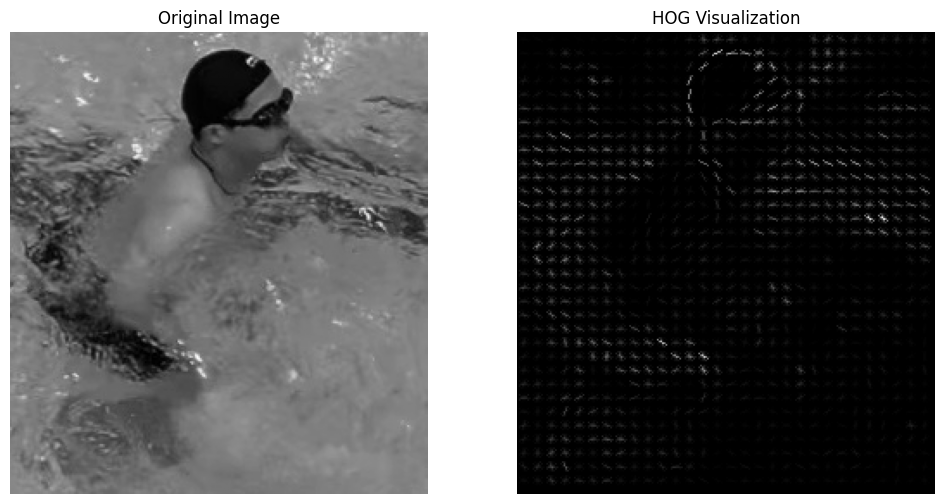

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

# Load a sample image
img_path = r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\cropped\train\000000.jpg'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Compute HOG features and the visualization
hog_features, hog_image = hog(image, 
                              orientations=9, 
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys', 
                              visualize=True)

# Display the original and HOG image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("HOG Visualization")
plt.axis('off')
plt.imshow(hog_image, cmap='gray')

plt.show()

In [76]:
import cv2
import os
import numpy as np
from sklearn import svm
import joblib

# Paths
pos_dir = os.path.join(os.getenv('CROPPED_DIR'), os.getenv('TRAIN_DIR'))
neg_dir = os.path.join(os.getenv('BACKGROUND_DIR'), os.getenv('TRAIN_DIR'))

# HOG Descriptor
hog = cv2.HOGDescriptor((128, 128), (16, 16), (8, 8), (8, 8), 9)

# Feature lists
features = []
labels = []

for img_file in os.listdir(pos_dir)[:2000]:
    img_path = os.path.join(pos_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    resized = cv2.resize(cropped, (128, 128))
    hog_feature = hog.compute(resized).flatten()

    features.append(hog_feature)
    labels.append(1)

for img_file in os.listdir(neg_dir)[:10000]:
    img_path = os.path.join(neg_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, (128, 128))
    hog_feature = hog.compute(img).flatten()
    features.append(hog_feature)
    labels.append(0)

features = np.array(features, dtype=np.float32)
labels = np.array(labels)

print(f"Total samples: {len(features)} (Positives: {sum(labels)}, Negatives: {len(labels) - sum(labels)})")

KeyboardInterrupt: 

In [69]:
# Train SVM
clf = svm.SVC(kernel='linear', C=0.01, probability=True)
clf.fit(features, labels)

# Save the model
joblib.dump(clf, 'hog_svm_human_detector.joblib')
print("Training completed and model saved as 'hog_svm_human_detector.joblib'")

Training completed and model saved as 'hog_svm_human_detector.joblib'


In [79]:
import cv2
import numpy as np
import joblib
from skimage.feature import hog
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

# Load the trained model
model_path = 'hog_svm_human_detector.joblib'
clf = joblib.load(model_path)

# HOG descriptor parameters (must match training)
win_size = (128, 128)  # Window size for HOG
hog = cv2.HOGDescriptor(win_size, (16, 16), (8, 8), (8, 8), 9)

# Load a test image
img_path = r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000001.jpg'
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
gray = cv2.resize(gray, (gray.shape[1] // 3, gray.shape[0] // 3))

# Sliding window parameters
step_size = 8
scale_factor = 1.1
bounding_boxes = []
confidences = []

# Multi-scale sliding window
for scale in np.arange(1, 3, 0.5):  # Test scales 1.0, 1.5, 2.0
    print(f"Processing scale: {scale:.2f}")
    resized_img = cv2.resize(gray, (int(gray.shape[1] / scale), int(gray.shape[0] / scale)))
    for y in range(0, resized_img.shape[0] - win_size[1], step_size):
        for x in range(0, resized_img.shape[1] - win_size[0], step_size):

            print(f"Processing window: ({x}, {y})")
            window = resized_img[y:y + win_size[1], x:x + win_size[0]]
            hog_feature = hog.compute(window).reshape(1, -1)

            print(f"Feature shape: {hog_feature.shape}")

            pred = clf.predict(hog_feature)
            confidence = clf.decision_function(hog_feature)[0]

            if pred == 1:  # Human detected
                x1 = int(x * scale)
                y1 = int(y * scale)
                x2 = int((x + win_size[0]) * scale)
                y2 = int((y + win_size[1]) * scale)

                bounding_boxes.append((x1, y1, x2, y2))
                confidences.append(confidence)

# Apply Non-Maximum Suppression (NMS)
final_boxes = non_max_suppression(np.array(bounding_boxes), probs=np.array(confidences), overlapThresh=0.3)

# Draw bounding boxes on the image
for (x1, y1, x2, y2) in final_boxes:
    cv2.rectangle(gray, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
cv2.imshow('HOG + SVM Human Detection', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()


Processing scale: 1.00
Processing window: (0, 0)
Feature shape: (1, 8100)
Processing window: (8, 0)
Feature shape: (1, 8100)
Processing window: (16, 0)
Feature shape: (1, 8100)
Processing window: (24, 0)
Feature shape: (1, 8100)
Processing window: (32, 0)
Feature shape: (1, 8100)
Processing window: (40, 0)
Feature shape: (1, 8100)
Processing window: (48, 0)
Feature shape: (1, 8100)
Processing window: (56, 0)
Feature shape: (1, 8100)
Processing window: (64, 0)
Feature shape: (1, 8100)
Processing window: (72, 0)
Feature shape: (1, 8100)
Processing window: (80, 0)
Feature shape: (1, 8100)
Processing window: (88, 0)
Feature shape: (1, 8100)
Processing window: (96, 0)
Feature shape: (1, 8100)
Processing window: (104, 0)
Feature shape: (1, 8100)
Processing window: (112, 0)
Feature shape: (1, 8100)
Processing window: (120, 0)
Feature shape: (1, 8100)
Processing window: (128, 0)
Feature shape: (1, 8100)
Processing window: (136, 0)
Feature shape: (1, 8100)
Processing window: (144, 0)
Feature sh

In [42]:
img = cv2.imread(r'C:\Users\hp\Downloads\BMCS 2133 Assignment\Drowning-Detection\data\images\train\000011.jpg')
img = cv2.resize(img, (img.shape[1] // 3, img.shape[0] // 3), interpolation=cv2.INTER_AREA)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

body_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

bodies = body_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=3, minSize=(20, 20))

# Draw bounding boxes
for (x, y, w, h) in bodies:
    cv2.rectangle(gray, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Show the output
cv2.imshow('Human Detection in Swimming Pool', gray)
cv2.imshow('Original Image', img)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2

body_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

# Load the video stream or image
cap = cv2.VideoCapture(0)  # Replace with 0 for webcam

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform detection
    bodies = body_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw bounding boxes
    for (x, y, w, h) in bodies:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Show the output
    cv2.imshow('Human Detection in Swimming Pool', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# CLASS_HUMAN = 0

# cap = cv2.VideoCapture(0)

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break


#     # Run YOLO inference
#     results = yolov11n(frame)

#     # print(results)

#     # print(results[0].boxes)

#     # print(results[0].boxes[0])

#     # break

#     for result in results:
#         boxes = result.boxes
#         for box in boxes:
#             cls = int(box.cls[0].item())
#             conf = box.conf[0].item()
#             x1, y1, x2, y2 = map(int, box.xyxy[0])

#             if True or cls == CLASS_HUMAN and conf > 0.5:
#                 cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
#                 cv2.putText(frame, f"Human {conf:.2f}", (x1, y1 - 10),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

#     # Show frame
#     cv2.imshow('Webcam Human Detection', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


0: 480x640 (no detections), 292.5ms
Speed: 7.3ms preprocess, 292.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 261.3ms
Speed: 5.9ms preprocess, 261.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 269.4ms
Speed: 4.3ms preprocess, 269.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 245.9ms
Speed: 4.9ms preprocess, 245.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 231.9ms
Speed: 4.0ms preprocess, 231.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 234.2ms
Speed: 3.3ms preprocess, 234.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 237.1ms
Speed: 5.8ms preprocess, 237.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 234.3ms
Speed: 4.9ms prepr